In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the data
df = pd.read_csv("note_query_data (2).csv")

In [3]:
df.head()

,subject_id,hadm_id,stay_id,admittime,dischtime,starttime,endtime,age,gender,min_po2,...,future_72hr_crp,future_72hr_lactate,future_72hr_bun,future_72hr_creatinine,future_72hr_ast,future_72hr_alt,future_72hr_inr,future_72hr_sodium,future_72hr_bicarb,future_72hr_vent_mode
0,13552692,23755923,31611905,2162-09-05 13:30:00,2162-09-08 12:44:00,2162-09-05 13:00:00,2162-09-06 08:00:00,49,F,39.0,...,NaN,1.5,14.0,0.9,41.0,63.0,0.9,141.0,21.0,NaN
1,11356876,24924829,32442329,2159-03-13 21:15:00,2159-03-28 00:00:00,2159-03-21 09:38:00,2159-03-22 07:00:00,67,F,24.0,...,NaN,2.7,29.0,1.1,655.0,221.0,1.6,146.0,21.0,NaN
2,19284747,24503251,35196996,2134-04-04 00:00:00,2134-05-21 14:00:00,2134-05-19 22:00:00,2134-05-20 00:00:00,49,M,NaN,...,NaN,NaN,39.0,2.5,NaN,NaN,2.3,134.0,30.0,NaN
3,18287462,25681759,39012007,2188-02-03 00:11:00,2188-02-20 19:00:00,2188-02-08 13:00:00,2188-02-11 07:00:00,63,F,66.0,...,NaN,3.1,39.0,3.5,NaN,NaN,1.1,131.0,21.0,PSV/SBT
4,18030946,27463454,33347764,2175-06-10 22:02:00,2175-06-18 14:00:00,2175-06-11 14:00:00,2175-06-12 09:00:00,80,F,33.0,...,NaN,NaN,25.0,1.2,NaN,NaN,1.0,140.0,31.0,CPAP/PSV


In [48]:
# To ensure each patient (hadm_id) appears only once, you can select the first ICU stay (stay_id) per hadm_id.
df_one_stay_per_admission = df.sort_values('admittime').drop_duplicates(subset='hadm_id', keep='first').copy()


In [49]:
df_no_reintubations.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime',
       'starttime', 'endtime', 'age', 'gender', 'min_po2', 'min_so2',
       'cumulative_vent_days', 'tracheostomy_flag', 'trach_date',
       'repeat_intubations', 'vap_flag', 'time_zero_intubation_resp_rate',
       'time_zero_intubation_heart_rate', 'time_zero_intubation_temperature',
       'time_zero_intubation_spo2', 'time_zero_intubation_tidal_volume',
       'time_zero_intubation_peep', 'time_zero_intubation_plateau_pressure',
       'time_zero_intubation_peak_pressure', 'time_zero_intubation_map',
       'time_zero_intubation_wbc', 'time_zero_intubation_hemoglobin',
       'time_zero_intubation_platelets', 'time_zero_intubation_crp',
       'time_zero_intubation_lactate', 'time_zero_intubation_bun',
       'time_zero_intubation_creatinine', 'time_zero_intubation_ast',
       'time_zero_intubation_alt', 'time_zero_intubation_inr',
       'time_zero_intubation_sodium', 'time_zero_intubation_bicarb',
       'tim

In [50]:
# Rename all columns starting with 'latest_intubation_' to 'time_zero_intubation_'
df.rename(
    columns={col: col.replace('latest_intubation_', 'time_zero_intubation_') 
             for col in df.columns if col.startswith('latest_intubation_')},
    inplace=True
)


In [38]:
# Remove any hadm_id with reintubation (repeat_intubations > 0)
df_no_reintubations = df_one_stay_per_admission[df_one_stay_per_admission['repeat_intubations'] == 0].copy()

In [39]:
df_no_reintubations['mechanical_power'] = (
    0.098 *
    df_no_reintubations['time_zero_intubation_resp_rate'] *
    (df_no_reintubations['time_zero_intubation_tidal_volume'] / 1000) *
    (df_no_reintubations['time_zero_intubation_peak_pressure'] - df_no_reintubations['time_zero_intubation_peep']) +
    df_no_reintubations['time_zero_intubation_peep']
)

In [40]:
# Impute 'mechanical_power' where values are negative or outliers (>1.5*IQR above Q3 or below Q1)
mp = df_no_reintubations['mechanical_power']

Q1 = mp.quantile(0.25)
Q3 = mp.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify invalid values: negative or outlier
invalid_mask = (mp < 0) | (mp < lower_bound) | (mp > upper_bound)

# Impute with median of valid values
valid_median = mp[~invalid_mask].median()
df_no_reintubations.loc[invalid_mask, 'mechanical_power'] = valid_median


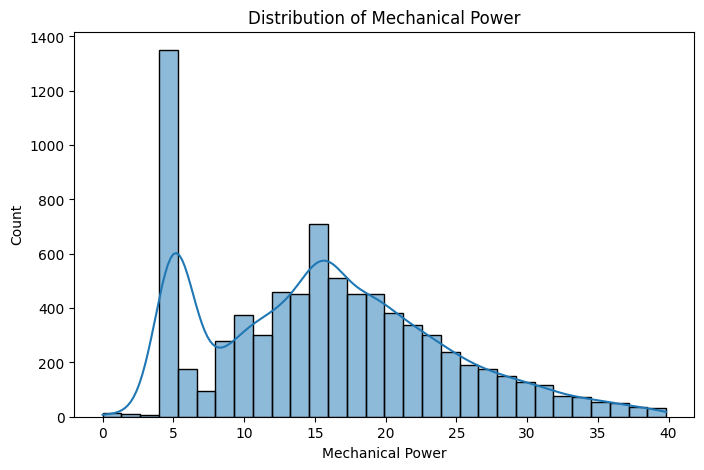

In [41]:
df_no_reintubations['mechanical_power'].describe()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_no_reintubations['mechanical_power'], kde=True, bins=30)
plt.title('Distribution of Mechanical Power')
plt.xlabel('Mechanical Power')
plt.ylabel('Count')
plt.show()


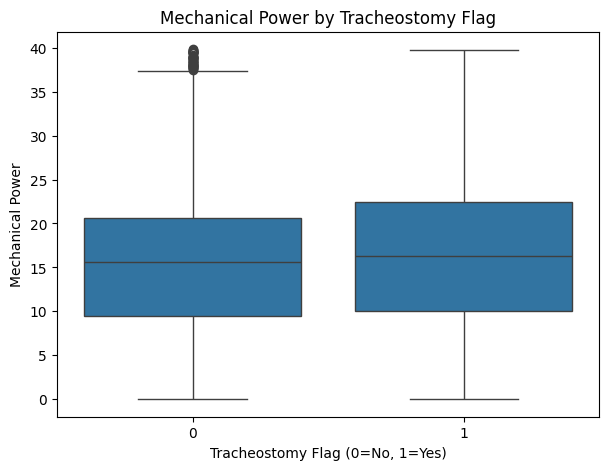

Mann-Whitney U test: U-statistic = 4445968.000, p-value = 1.19e-05
                   count     median       mean       std
tracheostomy_flag                                       
0                   6506  15.584000  15.707624  8.067005
1                   1474  16.275488  16.838501  8.606094


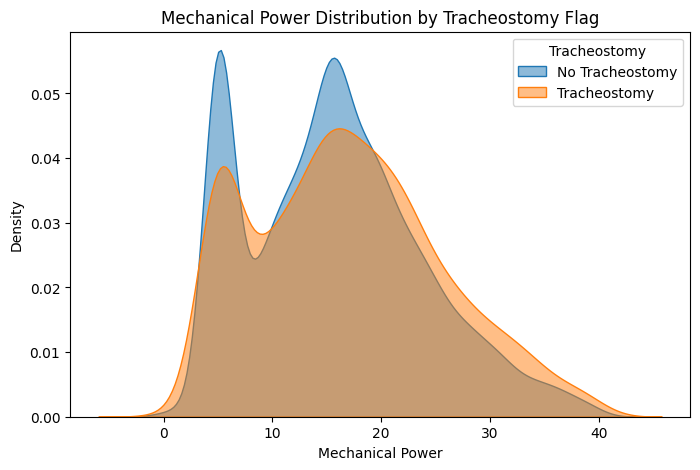

In [42]:
# Bivariate analysis: Mechanical Power vs Tracheostomy Flag

# Boxplot of mechanical power by tracheostomy flag
plt.figure(figsize=(7, 5))
sns.boxplot(x='tracheostomy_flag', y='mechanical_power', data=df_no_reintubations)
plt.title('Mechanical Power by Tracheostomy Flag')
plt.xlabel('Tracheostomy Flag (0=No, 1=Yes)')
plt.ylabel('Mechanical Power')
plt.show()

# Compare distributions with Mann-Whitney U test (non-parametric)
from scipy.stats import mannwhitneyu

mp_trach_0 = df_no_reintubations[df_no_reintubations['tracheostomy_flag'] == 0]['mechanical_power']
mp_trach_1 = df_no_reintubations[df_no_reintubations['tracheostomy_flag'] == 1]['mechanical_power']

u_stat, p_val = mannwhitneyu(mp_trach_0, mp_trach_1, alternative='two-sided', nan_policy='omit')
print(f"Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {p_val:.3g}")

# Show group medians and counts (non-parametric summary)
group_stats = df_no_reintubations.groupby('tracheostomy_flag')['mechanical_power'].agg(['count', 'median', 'mean', 'std'])
print(group_stats)

# Stacked KDE plot of mechanical power by tracheostomy flag
plt.figure(figsize=(8, 5))
for flag, label, color in zip([0, 1], ['No Tracheostomy', 'Tracheostomy'], ['#1f77b4', '#ff7f0e']):
    subset = df_no_reintubations[df_no_reintubations['tracheostomy_flag'] == flag]['mechanical_power']
    sns.kdeplot(subset, fill=True, alpha=0.5, label=label, color=color)
plt.title('Mechanical Power Distribution by Tracheostomy Flag')
plt.xlabel('Mechanical Power')
plt.ylabel('Density')
plt.legend(title='Tracheostomy')
plt.show()


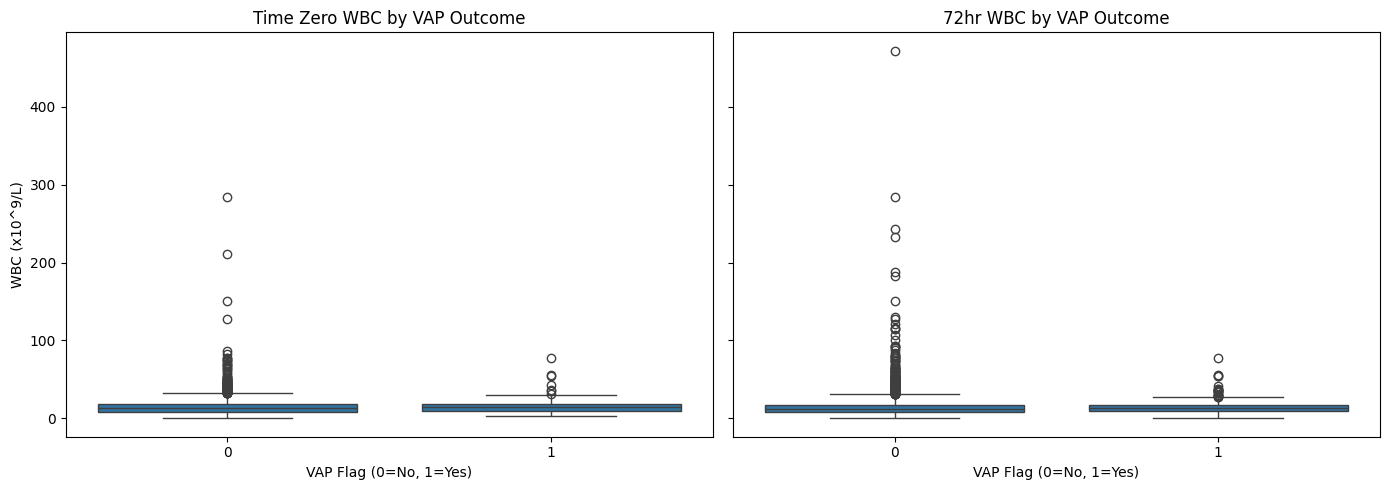

Time Zero WBC - Mann-Whitney U test: U-statistic = 239177.500, p-value = 0.0906
72hr WBC - Mann-Whitney U test: U-statistic = 1270829.000, p-value = 0.206

Time Zero WBC by VAP Flag:
          count  median       mean        std
vap_flag                                     
0          3472    12.8  14.704608  11.071966
1           150    14.2  15.722667   9.774746

72hr WBC by VAP Flag:
          count  median       mean        std
vap_flag                                     
0          7698    12.3  14.383724  12.268443
1           344    13.1  14.415116   8.550052


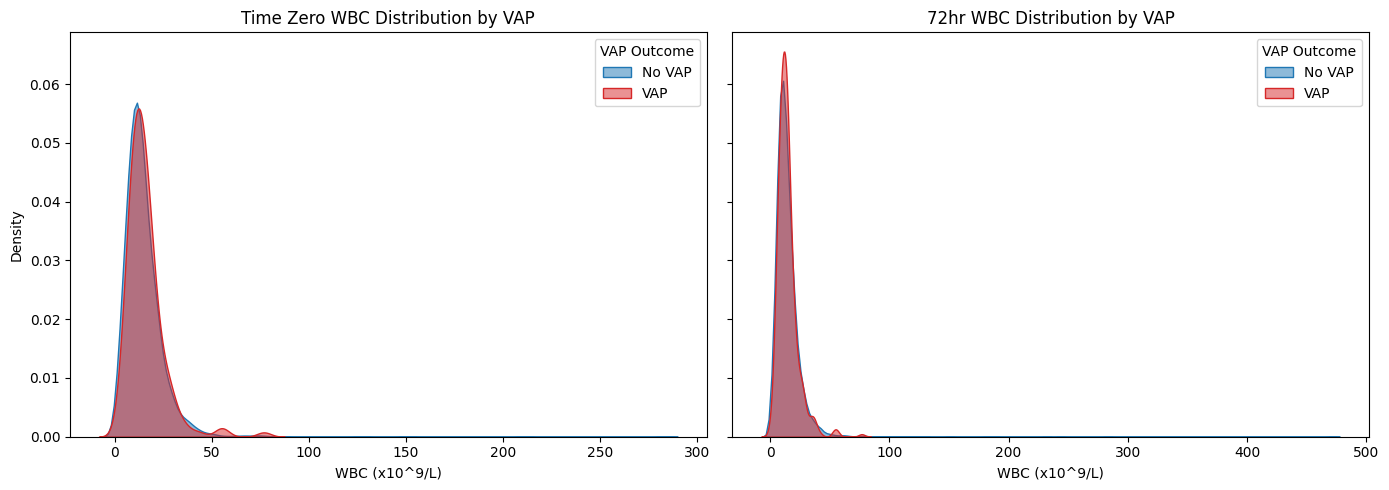

In [43]:
# Bivariate analysis: VAP outcome vs WBC at time zero and 72 hours later

# Boxplots of WBC by VAP flag at time zero and 72 hours
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.boxplot(
    x='vap_flag', 
    y='time_zero_intubation_wbc', 
    data=df_no_reintubations, 
    ax=axes[0]
)
axes[0].set_title('Time Zero WBC by VAP Outcome')
axes[0].set_xlabel('VAP Flag (0=No, 1=Yes)')
axes[0].set_ylabel('WBC (x10^9/L)')

sns.boxplot(
    x='vap_flag', 
    y='future_72hr_wbc', 
    data=df_no_reintubations, 
    ax=axes[1]
)
axes[1].set_title('72hr WBC by VAP Outcome')
axes[1].set_xlabel('VAP Flag (0=No, 1=Yes)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Mann-Whitney U test for WBC at time zero and 72hr by VAP outcome
from scipy.stats import mannwhitneyu

for col, label in zip(['time_zero_intubation_wbc', 'future_72hr_wbc'], ['Time Zero WBC', '72hr WBC']):
    wbc_vap_0 = df_no_reintubations[df_no_reintubations['vap_flag'] == 0][col]
    wbc_vap_1 = df_no_reintubations[df_no_reintubations['vap_flag'] == 1][col]
    u_stat, p_val = mannwhitneyu(wbc_vap_0, wbc_vap_1, alternative='two-sided', nan_policy='omit')
    print(f"{label} - Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {p_val:.3g}")

# Show group medians and counts for both timepoints
for col, label in zip(['time_zero_intubation_wbc', 'future_72hr_wbc'], ['Time Zero WBC', '72hr WBC']):
    print(f"\n{label} by VAP Flag:")
    print(df_no_reintubations.groupby('vap_flag')[col].agg(['count', 'median', 'mean', 'std']))

# KDE plots for WBC by VAP flag at both timepoints
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for flag, label, color in zip([0, 1], ['No VAP', 'VAP'], ['#1f77b4', '#d62728']):
    subset_0 = df_no_reintubations[df_no_reintubations['vap_flag'] == flag]['time_zero_intubation_wbc']
    subset_72 = df_no_reintubations[df_no_reintubations['vap_flag'] == flag]['future_72hr_wbc']
    sns.kdeplot(subset_0, fill=True, alpha=0.5, label=label, color=color, ax=axes[0])
    sns.kdeplot(subset_72, fill=True, alpha=0.5, label=label, color=color, ax=axes[1])

axes[0].set_title('Time Zero WBC Distribution by VAP')
axes[0].set_xlabel('WBC (x10^9/L)')
axes[0].set_ylabel('Density')
axes[0].legend(title='VAP Outcome')

axes[1].set_title('72hr WBC Distribution by VAP')
axes[1].set_xlabel('WBC (x10^9/L)')
axes[1].set_ylabel('Density')
axes[1].legend(title='VAP Outcome')

plt.tight_layout()
plt.show()


In [52]:
from sklearn.model_selection import train_test_split

# Example: Use all rows, drop non-feature columns for X, and predict 'vap_flag'
# Adjust feature/target selection as needed for your analysis
feature_cols = [col for col in df_no_reintubations.columns if col not in [
    'subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'starttime', 'endtime', 'vap_flag'
]]
X = df_no_reintubations[feature_cols]
y = df_no_reintubations['tracheostomy_flag']

# Split into train and test sets (80% train, 20% test, stratify by outcome)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 6590
Test set size: 1648


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Identify categorical columns (object or category dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical columns
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
if len(categorical_cols) > 0:
    X_train_enc = pd.get_dummies(X_train_enc, columns=categorical_cols)
    X_test_enc = pd.get_dummies(X_test_enc, columns=categorical_cols)
    # Ensure both train and test have the same columns
    X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# Train a decision tree classifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_enc, y_train)

# Predict on test set
y_pred = dtree.predict(X_test_enc)

# Print evaluation metrics
print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Decision Tree Test Accuracy: 1.0

Confusion Matrix:
 [[1345    0]
 [   0  303]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1345
           1       1.00      1.00      1.00       303

    accuracy                           1.00      1648
   macro avg       1.00      1.00      1.00      1648
weighted avg       1.00      1.00      1.00      1648



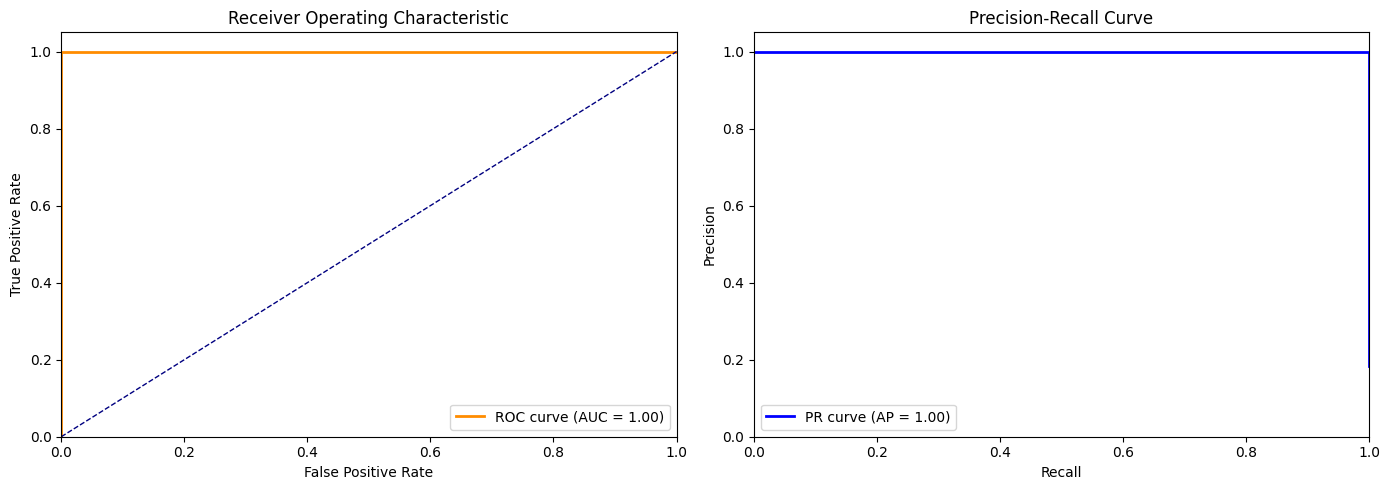

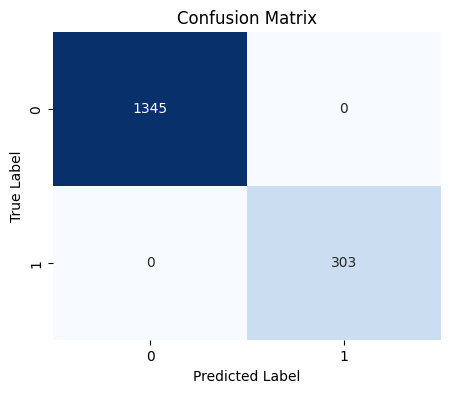

In [54]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the positive class
if hasattr(dtree, "predict_proba"):
    y_proba = dtree.predict_proba(X_test_enc)[:, 1]
else:
    # fallback for classifiers without predict_proba
    y_proba = dtree.decision_function(X_test_enc)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve and AUC
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

# Plot ROC and PR curves side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic')
axes[0].legend(loc="lower right")

# PR Curve
axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~

Best parameters found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validated F1 score: 0.980


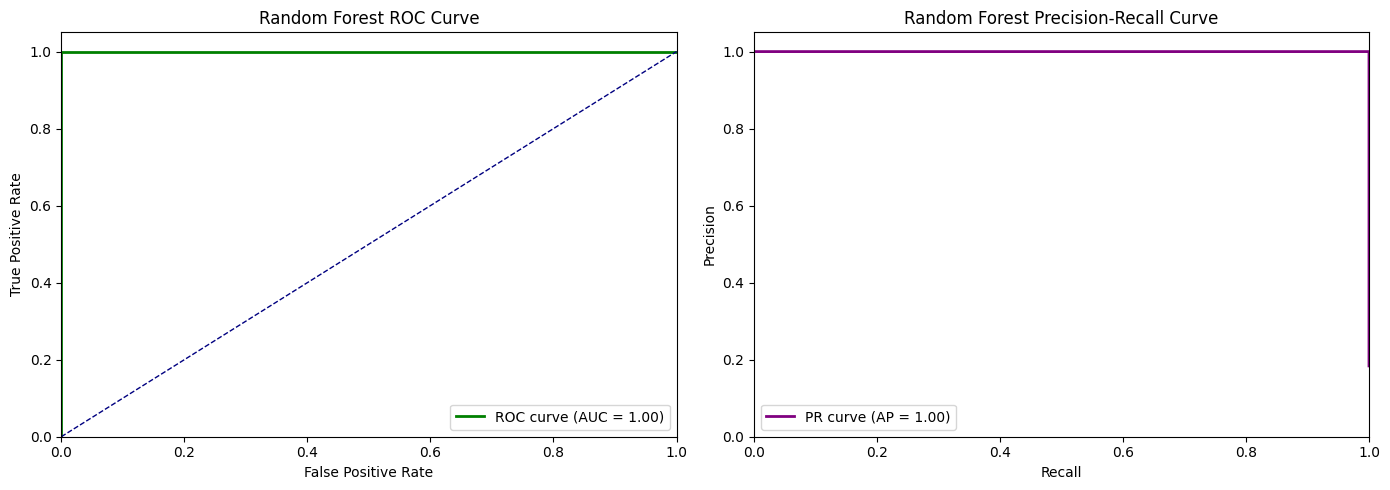

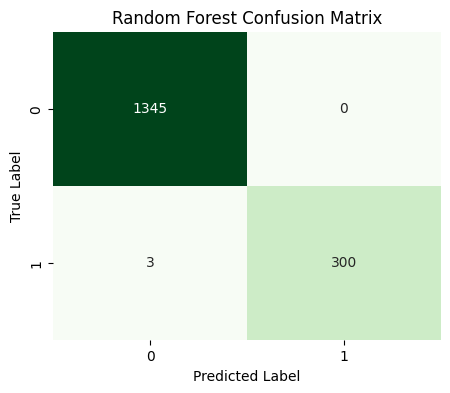

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up cross-validation strategy: Stratified KFold, 5 splits, 10 repeats
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Random Forest Classifier
rf_base = RandomForestClassifier(random_state=42)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_enc, y_train)

# Best estimator from search
rf = random_search.best_estimator_

print("Best parameters found:", random_search.best_params_)
print("Best cross-validated F1 score: {:.3f}".format(random_search.best_score_))

# Predict probabilities and classes
if hasattr(rf, "predict_proba"):
    y_proba_rf = rf.predict_proba(X_test_enc)[:, 1]
else:
    y_proba_rf = rf.decision_function(X_test_enc)
y_pred_rf = rf.predict(X_test_enc)

# ROC Curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Precision-Recall Curve and AUC
precision_rf, recall_rf, pr_thresholds_rf = precision_recall_curve(y_test, y_proba_rf)
pr_auc_rf = average_precision_score(y_test, y_proba_rf)

# Plot ROC and PR curves side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Random Forest ROC Curve')
axes[0].legend(loc="lower right")

# PR Curve
axes[1].plot(recall_rf, precision_rf, color='purple', lw=2, label=f'PR curve (AP = {pr_auc_rf:.2f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Random Forest Precision-Recall Curve')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# Confusion Matrix Plot for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()